In [103]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import random
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
from monai.inferers import sliding_window_inference
import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [104]:
def read_rgb_img(img_path):
    img= np.array(Image.open(img_path))
    orign_shape= img.shape[:2][::-1]
    return img, orign_shape

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ])
def get_pad_transform(img_size):
    return A.Compose([
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, p=1),
    ])
def get_crop_transform(img_size):
    return A.Compose([
        A.CenterCrop(img_size, img_size, p=1),
    ])

class Customize_Dataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.image_path = df['image_path'].values
        self.transforms = transforms
    
    def __getitem__(self, index):
        img_path = self.image_path[index]
        img, ori_shape= read_rgb_img(img_path)
        
        ## scale adjust
        img_size= min(img.shape[0], img.shape[1])
        img_size= img_size//CFG['img_scale']
        img_size= int(img_size)
        img= cv2.resize(img, (img_size, img_size))
        
        if img.shape[0]<CFG['window_size']:
            pad= img.shape[0]
            aug= get_pad_transform(CFG['window_size'])
            img= aug(image= img)['image']
        else:
            pad= 0
        
        img = self.transforms(image=img)["image"]
        return {
            'img_path': img_path,
            'image': torch.tensor(img/255, dtype=torch.float32),
            'ori_shape': torch.tensor(ori_shape),
            'pad': pad,
        }
    
    def __len__(self):
        return len(self.df)

# CFG

In [105]:
CFG= {
    'fold': 0,
    'img_scale': (4/1.24),
    'window_size': 768,
    'TTA': False,
    'model': None,
    'show_result': False,
}
CFG['model']= f"./train_model/model_cv{CFG['fold']}_best.pth"
# CFG['model']= f"./train_model/model_cv{CFG['fold']}_ep88.pth"
# CFG['model']= f"./test_model/effb7_w384_0.37/model_cv0_best.pth"

CFG['model']= [torch.load(CFG['model'], map_location= 'cuda:0')]

In [106]:
df= pd.read_csv('./Data/sample_submission.csv')
df['image_path']= None
for i in range(len(df)):
    id_= df.loc[i, ['id']].values[0]
    path= f'./Data/test_images/{id_}.tiff'
    df.loc[i, ['image_path']]= path
    
test_dataset= Customize_Dataset(df, get_test_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
df.head(3)

,id,rle,image_path
0,10078,12 34,./Data/test_images/10078.tiff


# Inference

In [107]:
def rle_encode(img):
    #the image should be transposed
    pixels = img.T.flatten()
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def inference(model, img):
    img= img.cuda()
    for i, m in enumerate(model):
        with torch.no_grad():
            m.eval()
            if CFG['TTA']:
                imgs= torch.cat([img, img.flip(-1), img.flip(-2), img.flip(-1).flip(-2)], dim=0)
                pred= sliding_window_inference(imgs, 
                                               (CFG['window_size'], CFG['window_size']), 
                                               sw_batch_size= 2, 
                                               predictor= m,
                                               mode= 'gaussian',
                                               overlap= 0.25)
                pred= (pred[0] + pred[1].flip(-1) + pred[2].flip(-2) + pred[3].flip(-1).flip(-2) ) / 4
            else:
                pred= sliding_window_inference(img, 
                                               (CFG['window_size'], CFG['window_size']), 
                                               sw_batch_size= 2, 
                                               predictor= m,
                                               mode= 'gaussian',
                                               overlap= 0.25)[0]
                
        if i==0: preds= pred.sigmoid()
        else: preds+= pred.sigmoid()
    pred= preds/len(model)
    pred= pred.cpu().permute(1,2,0).numpy()
    return pred

  0%|          | 0/1 [00:00<?, ?it/s]

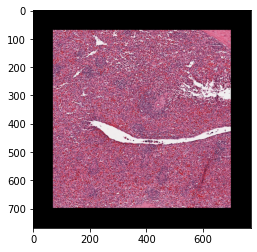

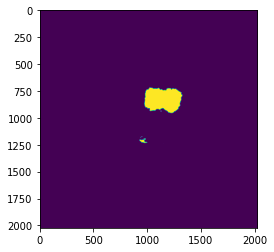

,id,rle,image_path
0,10078,1870459 7 1872480 10 1874501 13 1876523 14 187...,./Data/test_images/10078.tiff


In [110]:
indx= 0
for i, data in enumerate(tqdm(test_loader)):
    for j in range(len(data['image'])):
        img_path= data['img_path'][j]
        img= data['image'][j]
        ori_shape= data['ori_shape'][j].numpy()
        pad= data['pad'][j]
        
        ## inference
        img= torch.unsqueeze(img, dim= 0)
        pred_mask= inference(CFG['model'], img)
        
        ## if pad
        if pad!=0:
            aug= get_crop_transform(pad)
            pred_mask= aug(image= pred_mask)['image']
            pred_mask= cv2.resize(pred_mask, tuple(ori_shape))
        else:
            pred_mask= cv2.resize(pred_mask, tuple(ori_shape))
        
        thr= 0.5
        pred_mask[pred_mask>=thr]= 1
        pred_mask[pred_mask<thr]= 0
        pred_mask= pred_mask.astype(np.uint8)
        
        plt.imshow(img[0].permute(1,2,0).numpy())
        plt.show()
        plt.imshow(pred_mask)
        plt.show()
        rle= rle_encode(pred_mask)
        df.loc[indx, 'rle']= rle
        indx+= 1
df